## Неделя 2. Вторник 
### Обучение с учителем

### Применение ансаблей моделей для задач классификации и регрессии

1. Загружаем предобработанный датасет (либо загружаем и очищаем, если не осталось сохраненной версии)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
path = "/Users/verakabanova/foldeer_name/ds-phase-1-3/05-supervised/df_new.csv"

In [3]:
df = pd.read_csv(path)

2. К прежним датасетам применяем ансамбли моделей: 
    - `RandomForest`
    - `Voting`
    - `Catboost`([https://catboost.ai/en/docs/concepts/python-installation](https://catboost.ai/en/docs/concepts/python-installation))
    - `LightGBM`([https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html))
    - `XGBoost` ([https://xgboost.readthedocs.io/en/latest/install.html](https://xgboost.readthedocs.io/en/latest/install.html))

In [4]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
rf_opt = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
xgb_opt = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42, use_label_encoder=False, eval_metric='logloss')
lgb_opt = LGBMClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, num_leaves=31, random_state=42)
cb_opt = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, random_state=42, verbose=False)

print("Testing Optimized Models:")

rf_opt.fit(X_train, y_train)
print(f"RandomForest_Opt: {rf_opt.score(X_test, y_test):.4f}")

xgb_opt.fit(X_train, y_train)
print(f"XGBoost_Opt: {xgb_opt.score(X_test, y_test):.4f}")

lgb_opt.fit(X_train, y_train)
print(f"LightGBM_Opt: {lgb_opt.score(X_test, y_test):.4f}")

cb_opt.fit(X_train, y_train)
print(f"CatBoost_Opt: {cb_opt.score(X_test, y_test):.4f}")

Testing Optimized Models:


RandomForest_Opt: 0.8913
XGBoost_Opt: 0.8641
[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Info] Start training from score 0.213340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

# ❓
Какие значения по умолчанию заданы в случайном лесе для числа деревьев и их глубины?

> ответ тут. Число деревьев 100 , максимальная глубина None

3. Прогоните модели через `optuna`, определяем лучшие параметры и сохраняем результат в словарь вида:
    ```python
    results = {'model_name' : best_result}
    ```

Типичные параметры для оптимизации градиентного бустинга: 
* число итераций алгоритма
* глубина деревьев
* скорость обучения (`learning_rate`). 
Чтобы попробовать оптимизировать модели, стоит обратиться к документации: разные реализации будут предлагать разные варианты параметров. 

   > Для классификации используем метрику `accuracy_score`

In [6]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
], remainder='passthrough')

In [7]:
def optimize_model(model_class, param_suggestions, n_trials=50):
    def objective(trial):
        
        params = {}
        for param_name, suggestion in param_suggestions.items():
            if suggestion['type'] == 'int':
                params[param_name] = trial.suggest_int(param_name, *suggestion['range'])
            elif suggestion['type'] == 'float':
                params[param_name] = trial.suggest_float(param_name, *suggestion['range'])
            elif suggestion['type'] == 'categorical':
                params[param_name] = trial.suggest_categorical(param_name, suggestion['choices'])
        
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model_class(**params))
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_valid)
        return accuracy_score(y_valid, y_pred)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study.best_value

In [8]:
param_configs = {
    'RandomForest': {
        'n_estimators': {'type': 'int', 'range': (100, 500)},
        'max_depth': {'type': 'int', 'range': (3, 15)},
        'min_samples_split': {'type': 'int', 'range': (2, 20)},
        'min_samples_leaf': {'type': 'int', 'range': (1, 10)}
    },
    'XGBoost': {
        'n_estimators': {'type': 'int', 'range': (100, 500)},
        'max_depth': {'type': 'int', 'range': (3, 10)},
        'learning_rate': {'type': 'float', 'range': (0.01, 0.3)},
        'subsample': {'type': 'float', 'range': (0.6, 1.0)}
    },
    'LightGBM': {
        'n_estimators': {'type': 'int', 'range': (10, 50)},
        'max_depth': {'type': 'int', 'range': (3, 12)},
        'learning_rate': {'type': 'float', 'range': (0.01, 0.3)},
        'num_leaves': {'type': 'int', 'range': (20, 100)},
        'verbose': {'type': 'categorical', 'choices': [-1]}
    },
    'CatBoost': {
        'iterations': {'type': 'int', 'range': (100, 500)},
        'depth': {'type': 'int', 'range': (3, 10)},
        'learning_rate': {'type': 'float', 'range': (0.01, 0.3)},
        'l2_leaf_reg': {'type': 'float', 'range': (1, 10)},
        'verbose': {'type': 'categorical', 'choices': [False]}
    }
}

In [9]:
results = {}
best_pipelines = {}

for model_name, model_class in [
    ('RandomForest', RandomForestClassifier),
    ('XGBoost', XGBClassifier),
    ('LightGBM', LGBMClassifier),
    ('CatBoost', CatBoostClassifier)
]:
    print(f"Оптимизируем {model_name}...")
    
    best_params, best_score = optimize_model(
        model_class, 
        param_configs[model_name],
        n_trials=1
    )
    
    if model_name == 'LightGBM':
        best_params['verbose'] = -1
    elif model_name == 'CatBoost':
        best_params['verbose'] = False
    elif model_name == 'XGBoost':
        best_params['verbosity'] = 0
    
    best_params['random_state'] = 42
    
    best_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_class(**best_params))  
    ])
    
    best_pipeline.fit(X_temp, y_temp)  
    y_pred_test = best_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    results[model_name] = test_accuracy
    best_pipelines[model_name] = best_pipeline
    
    print(f" {model_name}: valid_score={best_score:.4f}, test_score={test_accuracy:.4f}")

Оптимизируем RandomForest...
 RandomForest: valid_score=0.9076, test_score=0.8804
Оптимизируем XGBoost...
 XGBoost: valid_score=0.8859, test_score=0.8587
Оптимизируем LightGBM...
 LightGBM: valid_score=0.9076, test_score=0.8641
Оптимизируем CatBoost...
 CatBoost: valid_score=0.8967, test_score=0.8696


In [10]:
print("\n Финальные результаты:")
for model_name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    data = f"'{model_name}': {accuracy:.4f}"
    print(data)


 Финальные результаты:
'RandomForest': 0.8804
'CatBoost': 0.8696
'LightGBM': 0.8641
'XGBoost': 0.8587


4. Превращаем словарь в `DataFrame` и сравниваем полученные результаты. Строим `bar_plot` для визуализации метрики качества. 

In [11]:
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
models = []
accuracies = []
for model_name, accuracy in sorted_results:
    models.append(model_name)
    accuracies.append(accuracy)

data = {"Model": models, "Accuracy": accuracies}

df = pd.DataFrame(data)


In [12]:
df.head()

,Model,Accuracy
0,RandomForest,0.880435
1,CatBoost,0.869565
2,LightGBM,0.864130
3,XGBoost,0.858696


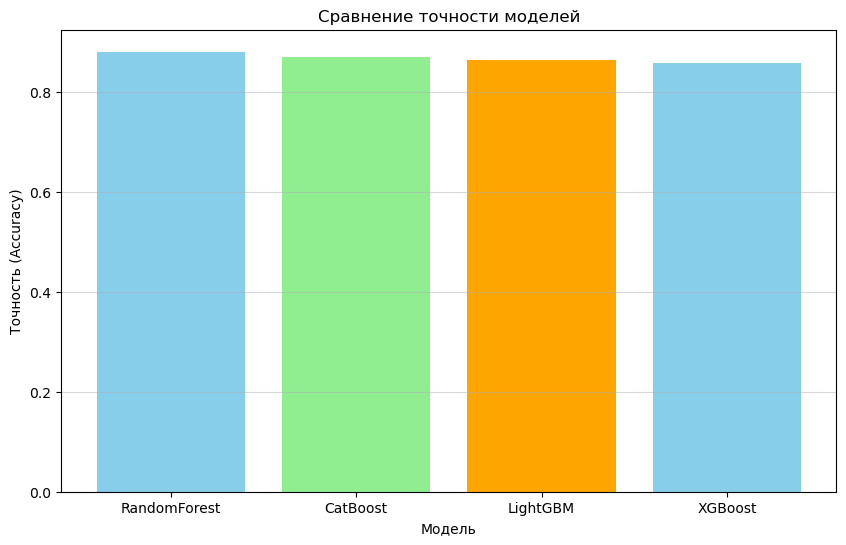

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6)) 

plt.bar(df['Model'], df['Accuracy'], color=['skyblue', 'lightgreen', 'orange'])

plt.xlabel('Модель')  
plt.ylabel('Точность (Accuracy)') 
plt.title('Сравнение точности моделей')  
plt.grid(axis='y', alpha=0.5)  

plt.show()

In [14]:
import joblib

joblib.dump(best_pipeline, 'best_model.pkl')  

print("✅ Модель сохранена!")

✅ Модель сохранена!


5. Выберете лучшую модель и попробуйте задеплоить ее в Streamlit.

* Создайте просто интерфейс для пользователя, куда бы он мог ввести необходимые данные, а вы бы ему вернули предсказание